In [1]:
import numpy as np
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy

np.set_printoptions(precision=6)
# initialize variables
N = 8
# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
B = 0.1     # !!! NEED TO BE CHANGED
J_matrix = np.zeros((N, N), dtype='float64')
J_value = 1
J_matrix_alpha = 1   # !!! NEED TO BE CHANGED
for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)


Nfeval =1
def callbackF(Xi):
    global Nfeval
    print ('{0:4d}   {1: 3.6f}'.format(Nfeval, lambda_evolve(Xi)))
    Nfeval += 1

In [2]:
# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')
B = 0.1  # Initial B value, when it's zero will be some deg  NEED TO BE CHANGED
B_not = 2

J_value = 1
J_matrix_alpha =  1 # NEED TO BE CHANGED
for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [3]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis

for n in range(Q):  # n is an unused index

    # couple_num_list would be my result for each state we loop

    if len(loop_state_list)!=0: # loop for couple number for one state

        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)

        for m in range(Q): # loop for spin and spatial for all states inside the couple number list

            if m==0:

                couple_num_list_old =couple_num_list

                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # spatial reflection
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)

                    # remove the repeated element
                    couple_num_list = np.unique(couple_num_list)
            else:

                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first
                    couple_num_list_old =couple_num_list

                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)


                        # spatial reflection
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)

                        # remove the repeated element
                        couple_num_list = np.unique(couple_num_list)

        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())

        # remove the ones already found
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))




In [4]:
# now we want to decide the sign for each term

for i in range(len(couple_state_matrix)):
#for i in range(1,2):

    state_num = couple_state_matrix[i]
    #print(state_num)

    # get spin & spatial reflection array without sign
    spin_num_array = np.zeros(len(state_num),dtype=int)
    spatial_num_array = np.zeros(len(state_num),dtype=int)

    for j in range(len(state_num)):

        array = D2B(state_num[j])

        # spin reflection
        spin_relfection_array = spin_reflection(array)
        spin_number = B2D(spin_relfection_array)
        spin_num_array[j] = spin_number
        #print(spin_num_array)

        # spatial reflection
        spatial_relfection_array = spatial_reflection(array)
        spatial_number = B2D(spatial_relfection_array)
        spatial_num_array[j] = spatial_number
        #print(spatial_num_array)


    # loop all possbie sign

    state_number_length = len(state_num)
    for j in range( pow(2,state_number_length) ):

        sign_array = D2B_with_digit(j,state_number_length)

        # convert it into 1 or -1

        for k in range(len(sign_array)):
            # the choice for sign here does not matter since we only the right + and -, what number it's is fine
            if sign_array[k] == 1:
                sign_array[k] = -1
            else:
                sign_array[k] = 1

        # combine signs on the reflection array sort is for comparison only

        temp_spin_num = spin_num_array * sign_array
        temp_spin_num = np.sort(temp_spin_num)
        #print(temp_spin_num)

        temp_spatial_num = spatial_num_array * sign_array
        temp_spatial_num =np.sort(temp_spatial_num)

        # combine the sign for the orginal state number array

        #temp_spin_b4_num = state_num * sign_array * -1   # this one is for odd parity
        temp_spin_b4_num = state_num * sign_array
        temp_spin_b4_num = np.sort(temp_spin_b4_num)

        #temp_spatial_b4_num = state_num * sign_array * -1 # this one is for odd parity
        temp_spatial_b4_num = state_num * sign_array
        temp_spatial_b4_num = np.sort(temp_spatial_b4_num)


        # check the parity here
        if np.array_equal(temp_spin_num,temp_spin_b4_num):

            if np.array_equal(temp_spatial_num,temp_spatial_b4_num):
                if sign_array[0]==1: # just so to pick out the positive ones since all negatives would also work
                    sign_matrix.append(sign_array.tolist())



In [5]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)

HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

In [6]:
# loop each basis to fill in the diagonal elements for HA matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # loop each element inside the array
    normalization = len(state_array)

    # energy total for all the product states inside one basis

    e_tot = 0
    for j in range(len(state_array)):

        state = D2B(state_array[j])

        # loop over N sites to change the state vector to either 1 or -1

        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs

        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

In [7]:
# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))

    for j in state_array:
        vector_form_basis_matrix[i][j] = 1

    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization



In [8]:
# loop each basis to fill in HB matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):

        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0


    # generate the vector form for the state after operrator acting on it

    vector_final_state = np.zeros(Q)

    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1

    # put back normalization factor
    vector_final_state = vector_final_state/normalization

    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):

        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product

In [9]:
# start looping for different B value
dB=0.0001 #
B_value_list = np.arange(B,B_not,dB) # the biggest value of B, change the sign if we change FM TO AFM

delta_e_list = []
delta_e_list_1 = []
delta_e_list_2 = []
delta_e_list_3 = []
delta_e_list_4 = []
delta_e_list_5 = []
for B_value in B_value_list:
    H_matrix = HA_matrix + B_value*HB_matrix
    vals, vecs = LA.eigh(H_matrix)
    # get gs parity

    #print(first_couple)
    delta_enengy = vals[1]- vals[0]
    delta_enengy_1 = vals[2]- vals[0]
    delta_enengy_2 = vals[3]- vals[0]
    delta_enengy_3 = vals[4]- vals[0]
    delta_enengy_4 = vals[5]- vals[0]
    delta_enengy_5 = vals[6]- vals[0]
    #print(delta_enengy)
    delta_e_list.append(delta_enengy)
    delta_e_list_1.append(delta_enengy_1)
    delta_e_list_2.append(delta_enengy_2)
    delta_e_list_3.append(delta_enengy_3)
    delta_e_list_4.append(delta_enengy_4)
    delta_e_list_5.append(delta_enengy_5)

In [10]:
delta_e_list = np.array(delta_e_list)
delta_e_list_1 = np.array(delta_e_list_1)
delta_e_list_2 = np.array(delta_e_list_2)
delta_e_list_3 = np.array(delta_e_list_3)
delta_e_list_4 = np.array(delta_e_list_4)
delta_e_list_5 = np.array(delta_e_list_5)

In [11]:
# # calculate delta energy value at 0
# vals, vecs = LA.eigh(HA_matrix)

# # add it back
# B_value_list = np.insert(B_value_list, 0, 0)

# delta_e_list = np.insert(delta_e_list, 0, vals[1]-vals[0])
# delta_e_list_1 = np.insert(delta_e_list_1, 0, vals[2]-vals[0])
# delta_e_list_2 = np.insert(delta_e_list_2, 0, vals[3]-vals[0])
# delta_e_list_3 = np.insert(delta_e_list_3, 0, vals[4]-vals[0])
# delta_e_list_4 = np.insert(delta_e_list_4, 0, vals[5]-vals[0])
# delta_e_list_5 = np.insert(delta_e_list_5, 0, vals[6]-vals[0])

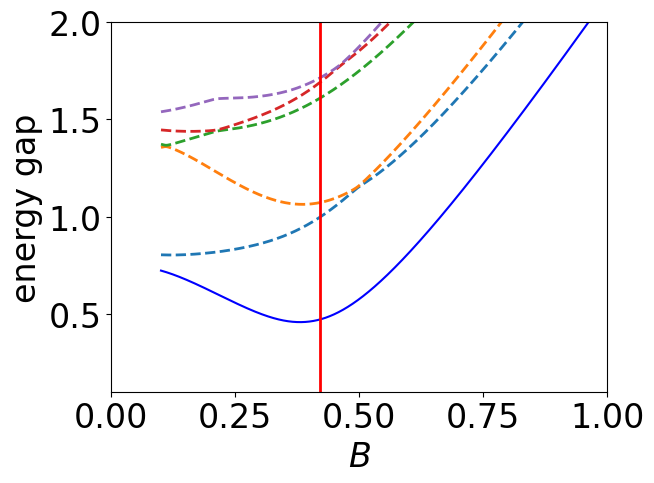

In [12]:
fig, ax = plt.subplots()
ax.plot(B_value_list,delta_e_list,color='blue')
ax.plot(B_value_list,delta_e_list_1,'--',lw=2)
ax.plot(B_value_list,delta_e_list_2,'--',lw=2)
ax.plot(B_value_list,delta_e_list_3,'--',lw=2)
ax.plot(B_value_list,delta_e_list_4,'--',lw=2)
ax.plot(B_value_list,delta_e_list_5,'--',lw=2)
ax.set(xlabel=r'$B$', ylabel='energy gap')
# Increase the font size of the labels
ax.tick_params(axis='both', labelsize=24)
# Set the font size for the axis labels
label_size =24
ax.xaxis.label.set_fontsize(label_size)  # Adjust the font size for the x-axis label
ax.yaxis.label.set_fontsize(label_size)  # Adjust the font size for the y-axis label

# ax.grid()
ax.set_xlim(0,1)
# ax.set_ylim(0.93,0.96)
ax.set_ylim(0.1,2)

# plot B critical
plt.vlines(0.42, 0, 6, color='red',lw=2)

# plt.text(0.4,3,'B_critical',size=20,color = 'red')

# latex_text = r'$B_{critical} =0.38$'
# ax.text(0.9, 5, latex_text, fontsize=22, ha='center', va='center',color ='red')

plt.savefig('B vs energy gap',bbox_inches='tight')
plt.show()


In [13]:
# save B field data
import pandas
df = pandas.DataFrame(data={"B": B_value_list, "d1": delta_e_list, "d2": delta_e_list_1, "d3": delta_e_list_2
                            , "d4": delta_e_list_3, "d5": delta_e_list_4, "d6": delta_e_list_5})
df.to_csv("energy_spec.csv", sep=',',index=False)

In [14]:
# NOTE, lA field data is included in Fig_1 folder , here provide how to get the energy spectrum

In [17]:
df_493 = pandas.read_csv('energy_spec_tf_493.csv')
df_long = pandas.read_csv('energy_spec_tf_11980.csv')

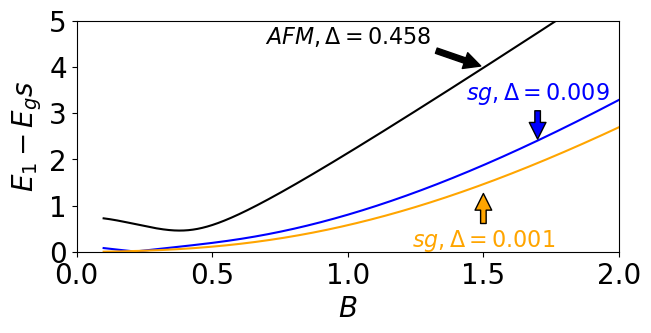

In [24]:
fig, ax = plt.subplots(figsize=(7, 3))  # Width = 10 inches, Height = 6 inches

# Plot the curves
ax.plot(B_value_list, delta_e_list, color='black')
ax.plot(df_493['B'], df_493['d1'], color='blue')
ax.plot(df_long['B'], df_long['d1'], color='orange')

# Set axis labels
ax.set(xlabel=r'$B$', ylabel=r'$E_1 -E_gs$')
label_size = 20
ax.tick_params(axis='both', labelsize=label_size)
ax.xaxis.label.set_fontsize(label_size)
ax.yaxis.label.set_fontsize(label_size)

# Set plot limits
ax.set_xlim(0, 2)
ax.set_ylim(0,5)

# Annotate the plot directly on the lines with matching colors
ax.annotate(r'$AFM,\Delta = 0.458$', xy=(1.5, 4), xytext=(1, 4.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16, color='black', ha='center')

ax.annotate(r'$sg, \Delta = 0.009$', xy=(1.7, 2.4), xytext=(1.7, 3.3),
            arrowprops=dict(facecolor='blue', shrink=0.05),
            fontsize=16, color='blue', ha='center')

ax.annotate(r'$sg, \Delta = 0.001$', xy=(1.5, 1.3), xytext=(1.5, 0.1),
            arrowprops=dict(facecolor='orange', shrink=0.05),
            fontsize=16, color='orange', ha='center')

# Set the y-ticks to include more values like 0.5, 1.0, etc.
ax.set_yticks([0,1,2,3,4,5])
# ax.set_xticks([0.1,0.5,1,1.5,2])

# Save the updated plot
plt.savefig('B_vs_energy_gap_afm_sg.png', bbox_inches='tight')
plt.show()